# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

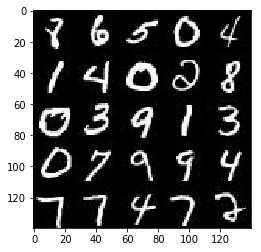

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

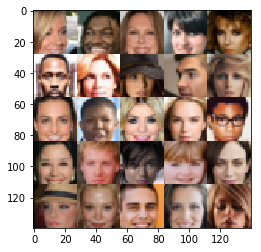

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0


/Users/arthur/Documents/anaconda3/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, 
                                shape = (None, image_width, image_height, image_channels), 
                                name = 'real_inputs')
    z_inputs = tf.placeholder(tf.float32, 
                            shape = (None, z_dim), 
                            name = 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, 
                                  name = 'learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):        
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.maximum(alpha * conv2, conv2)
        conv2 = tf.layers.batch_normalization(conv2, training=True)        
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.maximum(alpha * conv3, conv3)
        conv3 = tf.layers.batch_normalization(conv3, training=True)        
        
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope("generator", reuse=not is_train):
        x = tf.layers.dense(z, 2*2*512)
        x = tf.reshape(x, (-1, 2, 2, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding="valid")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding="same")
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z,out_channel_dim,is_train=True)
    
    d_model_real,d_logits_real =discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake =discriminator(gen_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(
                  logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(
                  logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(
             logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                       beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                       beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    real_inputs, z_inputs, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, z_inputs, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 0/2... Discriminator Loss: 0.7017... Generator Loss: 19.4727
Epoch 0/2... Discriminator Loss: 0.7001... Generator Loss: 11.9925
Epoch 0/2... Discriminator Loss: 0.5534... Generator Loss: 18.1073
Epoch 0/2... Discriminator Loss: 1.7841... Generator Loss: 0.6145


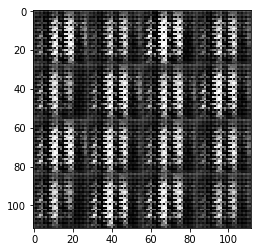

Epoch 0/2... Discriminator Loss: 1.1657... Generator Loss: 17.8476
Epoch 0/2... Discriminator Loss: 0.4397... Generator Loss: 5.3146
Epoch 0/2... Discriminator Loss: 0.5333... Generator Loss: 2.2022
Epoch 0/2... Discriminator Loss: 0.6167... Generator Loss: 2.7895
Epoch 0/2... Discriminator Loss: 0.4460... Generator Loss: 3.0774


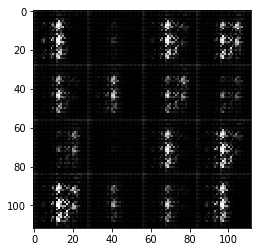

Epoch 0/2... Discriminator Loss: 0.4240... Generator Loss: 3.6951
Epoch 0/2... Discriminator Loss: 0.6633... Generator Loss: 1.9645
Epoch 0/2... Discriminator Loss: 0.5432... Generator Loss: 2.4115
Epoch 0/2... Discriminator Loss: 0.3907... Generator Loss: 5.2954
Epoch 0/2... Discriminator Loss: 0.4165... Generator Loss: 3.4064


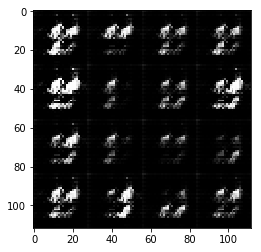

Epoch 0/2... Discriminator Loss: 0.4473... Generator Loss: 3.3701
Epoch 0/2... Discriminator Loss: 0.4114... Generator Loss: 4.6679
Epoch 0/2... Discriminator Loss: 1.7952... Generator Loss: 0.3793
Epoch 0/2... Discriminator Loss: 0.5605... Generator Loss: 2.9037
Epoch 0/2... Discriminator Loss: 0.7676... Generator Loss: 4.7355


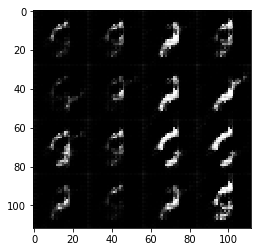

Epoch 0/2... Discriminator Loss: 0.4687... Generator Loss: 2.9320
Epoch 0/2... Discriminator Loss: 0.4830... Generator Loss: 2.6280
Epoch 0/2... Discriminator Loss: 0.5043... Generator Loss: 3.8342
Epoch 0/2... Discriminator Loss: 0.5942... Generator Loss: 2.5047
Epoch 0/2... Discriminator Loss: 0.4787... Generator Loss: 3.1238


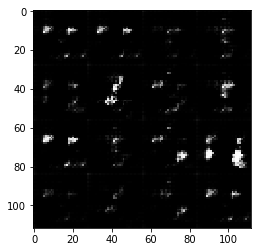

Epoch 0/2... Discriminator Loss: 0.5735... Generator Loss: 2.7371
Epoch 0/2... Discriminator Loss: 0.5178... Generator Loss: 2.8589
Epoch 0/2... Discriminator Loss: 0.8117... Generator Loss: 1.6608
Epoch 0/2... Discriminator Loss: 0.5944... Generator Loss: 4.5300
Epoch 0/2... Discriminator Loss: 0.4901... Generator Loss: 3.4042


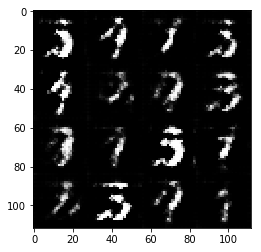

Epoch 0/2... Discriminator Loss: 0.6880... Generator Loss: 2.4469
Epoch 0/2... Discriminator Loss: 0.6576... Generator Loss: 3.1628
Epoch 0/2... Discriminator Loss: 0.5105... Generator Loss: 2.9956
Epoch 0/2... Discriminator Loss: 0.6774... Generator Loss: 3.1927
Epoch 0/2... Discriminator Loss: 0.4972... Generator Loss: 2.5694


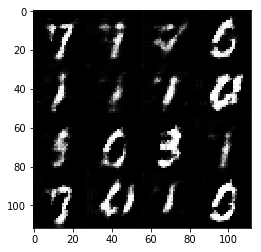

Epoch 0/2... Discriminator Loss: 0.5741... Generator Loss: 2.0324
Epoch 0/2... Discriminator Loss: 0.7650... Generator Loss: 4.7507
Epoch 0/2... Discriminator Loss: 0.8511... Generator Loss: 1.4980
Epoch 0/2... Discriminator Loss: 0.7912... Generator Loss: 3.8270
Epoch 0/2... Discriminator Loss: 0.5225... Generator Loss: 2.6065


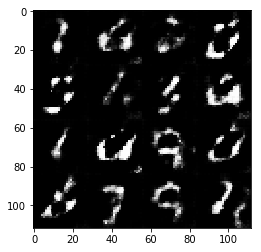

Epoch 0/2... Discriminator Loss: 1.3032... Generator Loss: 0.6948
Epoch 0/2... Discriminator Loss: 0.6944... Generator Loss: 1.7320
Epoch 0/2... Discriminator Loss: 0.6993... Generator Loss: 1.7099
Epoch 0/2... Discriminator Loss: 0.8083... Generator Loss: 1.9018
Epoch 0/2... Discriminator Loss: 1.1134... Generator Loss: 3.8983


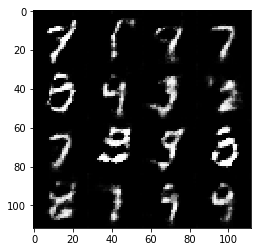

Epoch 0/2... Discriminator Loss: 0.8506... Generator Loss: 1.4470
Epoch 0/2... Discriminator Loss: 0.7404... Generator Loss: 1.8955
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 2.8015
Epoch 1/2... Discriminator Loss: 0.6834... Generator Loss: 1.7460
Epoch 1/2... Discriminator Loss: 0.8899... Generator Loss: 2.5821


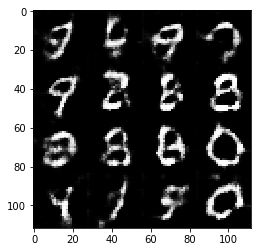

Epoch 1/2... Discriminator Loss: 0.8114... Generator Loss: 1.3930
Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 2.0595
Epoch 1/2... Discriminator Loss: 1.0285... Generator Loss: 0.9724
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 0.8376
Epoch 1/2... Discriminator Loss: 0.8542... Generator Loss: 1.4712


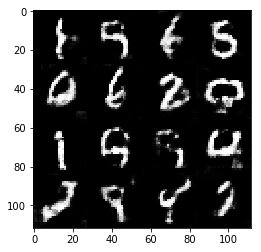

Epoch 1/2... Discriminator Loss: 0.8349... Generator Loss: 1.4485
Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 0.6314
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.0408
Epoch 1/2... Discriminator Loss: 0.8898... Generator Loss: 2.0096
Epoch 1/2... Discriminator Loss: 0.9610... Generator Loss: 1.0820


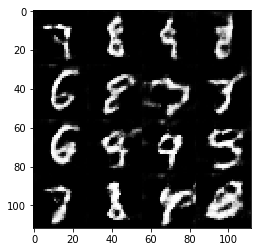

Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 1.4222
Epoch 1/2... Discriminator Loss: 0.9240... Generator Loss: 1.6991
Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 1.2620
Epoch 1/2... Discriminator Loss: 1.2520... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 0.9017... Generator Loss: 1.6676


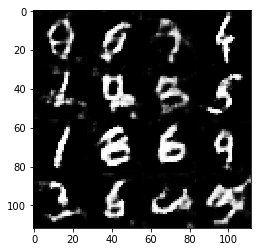

Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 0.8569
Epoch 1/2... Discriminator Loss: 1.2220... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.5927
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 2.6904


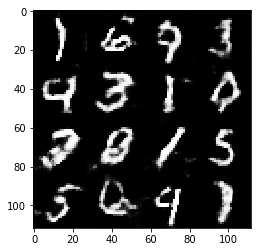

Epoch 1/2... Discriminator Loss: 0.8230... Generator Loss: 1.6617
Epoch 1/2... Discriminator Loss: 1.2417... Generator Loss: 3.1800
Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 0.8739
Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 0.8715
Epoch 1/2... Discriminator Loss: 0.8602... Generator Loss: 1.3778


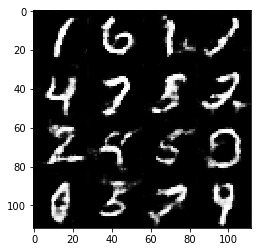

Epoch 1/2... Discriminator Loss: 1.7356... Generator Loss: 4.0130
Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 2.0876
Epoch 1/2... Discriminator Loss: 0.8883... Generator Loss: 1.0514
Epoch 1/2... Discriminator Loss: 0.7415... Generator Loss: 2.2055
Epoch 1/2... Discriminator Loss: 0.8287... Generator Loss: 1.3307


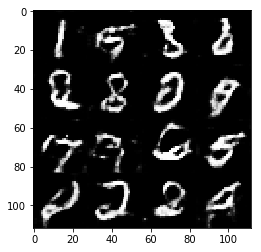

Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 2.7278
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 2.3950
Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 1.3146
Epoch 1/2... Discriminator Loss: 1.1045... Generator Loss: 0.8640
Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 1.2326


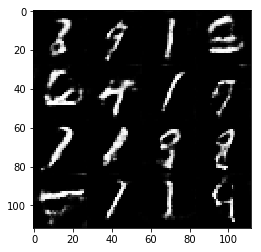

Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 0.9809
Epoch 1/2... Discriminator Loss: 1.7496... Generator Loss: 0.3891
Epoch 1/2... Discriminator Loss: 1.7292... Generator Loss: 3.2897
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 1.0224
Epoch 1/2... Discriminator Loss: 0.9549... Generator Loss: 1.0485


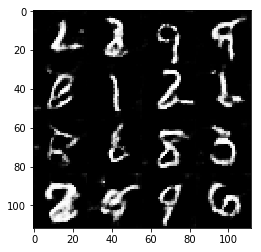

Epoch 1/2... Discriminator Loss: 0.8326... Generator Loss: 1.3420
Epoch 1/2... Discriminator Loss: 1.5386... Generator Loss: 0.4765
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 1.2720... Generator Loss: 2.6705


In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.50


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 0/1... Discriminator Loss: 7.0936... Generator Loss: 0.0024
Epoch 0/1... Discriminator Loss: 1.7227... Generator Loss: 10.5985
Epoch 0/1... Discriminator Loss: 1.0689... Generator Loss: 15.5553
Epoch 0/1... Discriminator Loss: 1.8301... Generator Loss: 1.6830


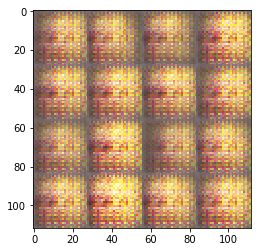

Epoch 0/1... Discriminator Loss: 0.9118... Generator Loss: 2.7769
Epoch 0/1... Discriminator Loss: 1.1463... Generator Loss: 3.0035
Epoch 0/1... Discriminator Loss: 0.8797... Generator Loss: 1.8159
Epoch 0/1... Discriminator Loss: 0.9256... Generator Loss: 2.2099
Epoch 0/1... Discriminator Loss: 1.9462... Generator Loss: 5.5134


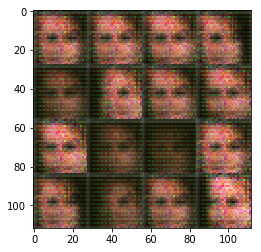

Epoch 0/1... Discriminator Loss: 0.7353... Generator Loss: 1.4394
Epoch 0/1... Discriminator Loss: 0.9394... Generator Loss: 2.0228
Epoch 0/1... Discriminator Loss: 1.5587... Generator Loss: 1.7390
Epoch 0/1... Discriminator Loss: 1.0540... Generator Loss: 1.1445
Epoch 0/1... Discriminator Loss: 1.4095... Generator Loss: 0.6733


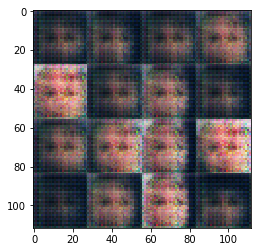

Epoch 0/1... Discriminator Loss: 1.0728... Generator Loss: 1.6776
Epoch 0/1... Discriminator Loss: 1.5283... Generator Loss: 0.9759
Epoch 0/1... Discriminator Loss: 1.0624... Generator Loss: 1.2430
Epoch 0/1... Discriminator Loss: 0.9159... Generator Loss: 1.4424
Epoch 0/1... Discriminator Loss: 1.9096... Generator Loss: 0.3164


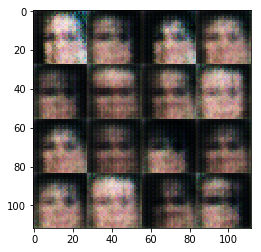

Epoch 0/1... Discriminator Loss: 1.0762... Generator Loss: 1.9015
Epoch 0/1... Discriminator Loss: 0.9466... Generator Loss: 2.2117
Epoch 0/1... Discriminator Loss: 1.2602... Generator Loss: 0.9522
Epoch 0/1... Discriminator Loss: 1.0605... Generator Loss: 1.6600
Epoch 0/1... Discriminator Loss: 1.2356... Generator Loss: 1.5472


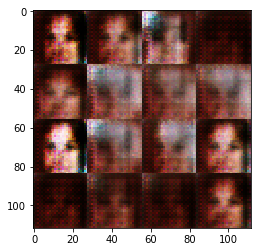

Epoch 0/1... Discriminator Loss: 0.9226... Generator Loss: 1.3563
Epoch 0/1... Discriminator Loss: 1.3516... Generator Loss: 1.0627
Epoch 0/1... Discriminator Loss: 1.4414... Generator Loss: 0.8858
Epoch 0/1... Discriminator Loss: 1.1323... Generator Loss: 1.3056
Epoch 0/1... Discriminator Loss: 1.1829... Generator Loss: 1.5376


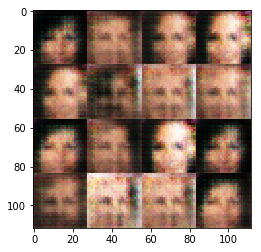

Epoch 0/1... Discriminator Loss: 1.4158... Generator Loss: 2.2139
Epoch 0/1... Discriminator Loss: 1.2038... Generator Loss: 0.8582
Epoch 0/1... Discriminator Loss: 1.3861... Generator Loss: 2.8094
Epoch 0/1... Discriminator Loss: 1.0306... Generator Loss: 1.3865
Epoch 0/1... Discriminator Loss: 1.8794... Generator Loss: 0.4777


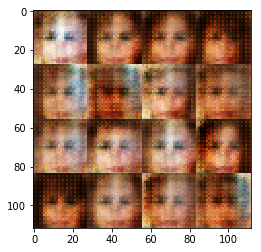

Epoch 0/1... Discriminator Loss: 1.1046... Generator Loss: 1.7117
Epoch 0/1... Discriminator Loss: 0.8848... Generator Loss: 1.6964
Epoch 0/1... Discriminator Loss: 1.2655... Generator Loss: 1.0187
Epoch 0/1... Discriminator Loss: 1.4048... Generator Loss: 1.2270
Epoch 0/1... Discriminator Loss: 1.0319... Generator Loss: 1.0413


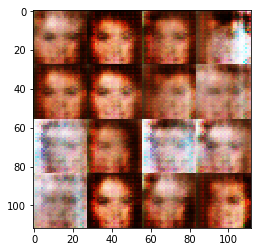

Epoch 0/1... Discriminator Loss: 1.0544... Generator Loss: 1.0364
Epoch 0/1... Discriminator Loss: 2.5452... Generator Loss: 0.2271
Epoch 0/1... Discriminator Loss: 0.8322... Generator Loss: 1.5074
Epoch 0/1... Discriminator Loss: 0.8996... Generator Loss: 1.1726
Epoch 0/1... Discriminator Loss: 1.1774... Generator Loss: 1.0543


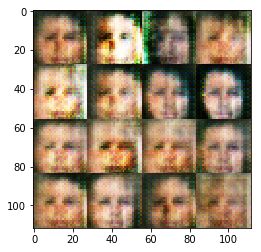

Epoch 0/1... Discriminator Loss: 1.4131... Generator Loss: 1.0401
Epoch 0/1... Discriminator Loss: 1.1348... Generator Loss: 0.9730
Epoch 0/1... Discriminator Loss: 1.2858... Generator Loss: 2.5008
Epoch 0/1... Discriminator Loss: 0.9088... Generator Loss: 3.5188
Epoch 0/1... Discriminator Loss: 0.9964... Generator Loss: 1.4808


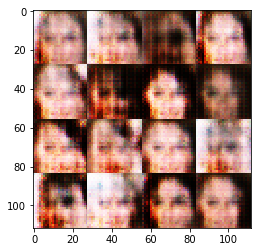

Epoch 0/1... Discriminator Loss: 1.1150... Generator Loss: 1.3607
Epoch 0/1... Discriminator Loss: 1.2230... Generator Loss: 0.8851
Epoch 0/1... Discriminator Loss: 1.9195... Generator Loss: 3.1914
Epoch 0/1... Discriminator Loss: 0.5391... Generator Loss: 2.5245
Epoch 0/1... Discriminator Loss: 1.4568... Generator Loss: 0.8064


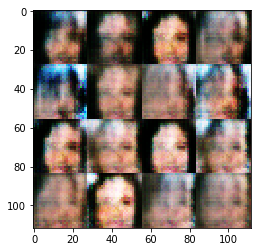

Epoch 0/1... Discriminator Loss: 1.2469... Generator Loss: 2.1730
Epoch 0/1... Discriminator Loss: 0.8530... Generator Loss: 1.6405
Epoch 0/1... Discriminator Loss: 1.0485... Generator Loss: 1.2795
Epoch 0/1... Discriminator Loss: 0.9994... Generator Loss: 1.3507
Epoch 0/1... Discriminator Loss: 1.0970... Generator Loss: 1.2118


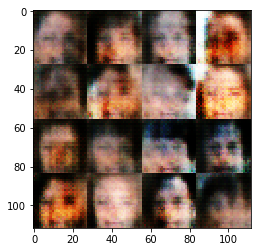

Epoch 0/1... Discriminator Loss: 0.8341... Generator Loss: 1.2716
Epoch 0/1... Discriminator Loss: 1.2295... Generator Loss: 2.2242
Epoch 0/1... Discriminator Loss: 0.8356... Generator Loss: 1.6832
Epoch 0/1... Discriminator Loss: 1.2417... Generator Loss: 3.3450
Epoch 0/1... Discriminator Loss: 1.2419... Generator Loss: 0.7718


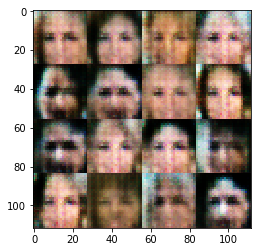

Epoch 0/1... Discriminator Loss: 1.1686... Generator Loss: 0.9391
Epoch 0/1... Discriminator Loss: 0.9950... Generator Loss: 2.0841
Epoch 0/1... Discriminator Loss: 1.8598... Generator Loss: 0.5528
Epoch 0/1... Discriminator Loss: 0.8084... Generator Loss: 1.3360
Epoch 0/1... Discriminator Loss: 1.3765... Generator Loss: 2.1157


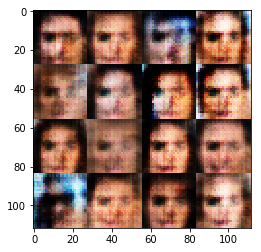

Epoch 0/1... Discriminator Loss: 0.9782... Generator Loss: 1.6113
Epoch 0/1... Discriminator Loss: 0.9890... Generator Loss: 1.3714
Epoch 0/1... Discriminator Loss: 0.9501... Generator Loss: 1.6099
Epoch 0/1... Discriminator Loss: 0.9619... Generator Loss: 2.8577
Epoch 0/1... Discriminator Loss: 0.9850... Generator Loss: 1.8768


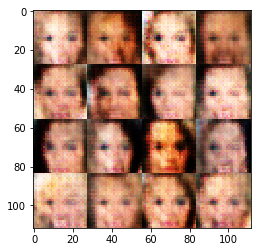

Epoch 0/1... Discriminator Loss: 1.0518... Generator Loss: 1.6822
Epoch 0/1... Discriminator Loss: 1.0363... Generator Loss: 1.2255
Epoch 0/1... Discriminator Loss: 1.2043... Generator Loss: 0.8062
Epoch 0/1... Discriminator Loss: 0.9540... Generator Loss: 2.1518
Epoch 0/1... Discriminator Loss: 0.8825... Generator Loss: 1.4717


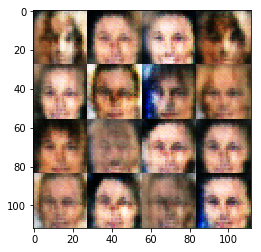

Epoch 0/1... Discriminator Loss: 0.9133... Generator Loss: 2.0843
Epoch 0/1... Discriminator Loss: 0.9456... Generator Loss: 2.1127
Epoch 0/1... Discriminator Loss: 1.3283... Generator Loss: 1.0039
Epoch 0/1... Discriminator Loss: 0.9087... Generator Loss: 1.7480
Epoch 0/1... Discriminator Loss: 1.0183... Generator Loss: 1.7968


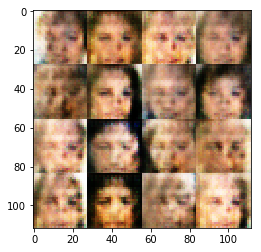

Epoch 0/1... Discriminator Loss: 1.7221... Generator Loss: 0.4056
Epoch 0/1... Discriminator Loss: 1.0281... Generator Loss: 1.0299
Epoch 0/1... Discriminator Loss: 0.8014... Generator Loss: 1.3680
Epoch 0/1... Discriminator Loss: 0.9594... Generator Loss: 1.3843
Epoch 0/1... Discriminator Loss: 1.1006... Generator Loss: 0.9562


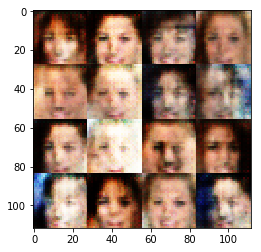

Epoch 0/1... Discriminator Loss: 1.1573... Generator Loss: 1.0857
Epoch 0/1... Discriminator Loss: 0.8994... Generator Loss: 1.8840
Epoch 0/1... Discriminator Loss: 1.2939... Generator Loss: 0.9605
Epoch 0/1... Discriminator Loss: 0.8557... Generator Loss: 1.4764
Epoch 0/1... Discriminator Loss: 1.4542... Generator Loss: 0.6185


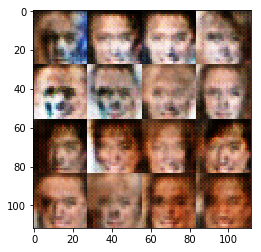

Epoch 0/1... Discriminator Loss: 0.8895... Generator Loss: 1.3148
Epoch 0/1... Discriminator Loss: 0.9384... Generator Loss: 1.1975
Epoch 0/1... Discriminator Loss: 0.8824... Generator Loss: 1.6992
Epoch 0/1... Discriminator Loss: 2.6767... Generator Loss: 4.3036
Epoch 0/1... Discriminator Loss: 1.0472... Generator Loss: 1.7600


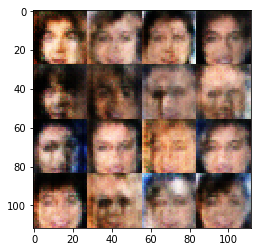

Epoch 0/1... Discriminator Loss: 2.0296... Generator Loss: 3.4531
Epoch 0/1... Discriminator Loss: 0.9556... Generator Loss: 1.1882
Epoch 0/1... Discriminator Loss: 0.7908... Generator Loss: 1.7842
Epoch 0/1... Discriminator Loss: 0.9863... Generator Loss: 1.3879
Epoch 0/1... Discriminator Loss: 0.7791... Generator Loss: 1.4627


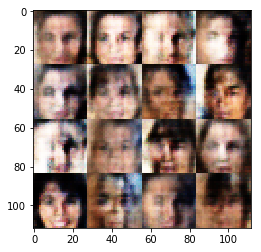

Epoch 0/1... Discriminator Loss: 1.1129... Generator Loss: 0.8884
Epoch 0/1... Discriminator Loss: 0.9429... Generator Loss: 1.6053
Epoch 0/1... Discriminator Loss: 1.0930... Generator Loss: 0.9563
Epoch 0/1... Discriminator Loss: 1.1411... Generator Loss: 2.0786
Epoch 0/1... Discriminator Loss: 0.9642... Generator Loss: 1.3941


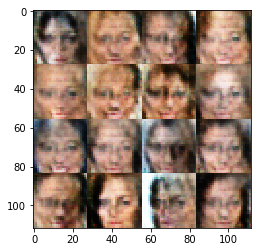

Epoch 0/1... Discriminator Loss: 1.0299... Generator Loss: 1.0808
Epoch 0/1... Discriminator Loss: 0.7196... Generator Loss: 2.1792
Epoch 0/1... Discriminator Loss: 0.8159... Generator Loss: 1.7450
Epoch 0/1... Discriminator Loss: 0.9893... Generator Loss: 1.3315
Epoch 0/1... Discriminator Loss: 0.9021... Generator Loss: 1.4294


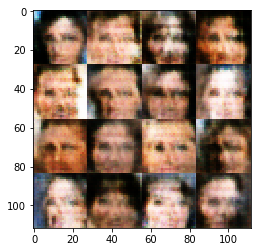

Epoch 0/1... Discriminator Loss: 0.9175... Generator Loss: 1.7408
Epoch 0/1... Discriminator Loss: 0.9716... Generator Loss: 1.0482
Epoch 0/1... Discriminator Loss: 1.0601... Generator Loss: 1.2462
Epoch 0/1... Discriminator Loss: 0.8526... Generator Loss: 1.2889
Epoch 0/1... Discriminator Loss: 0.8349... Generator Loss: 1.5087


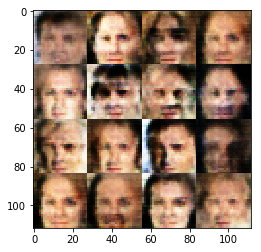

Epoch 0/1... Discriminator Loss: 1.8239... Generator Loss: 0.4267
Epoch 0/1... Discriminator Loss: 0.9214... Generator Loss: 1.1878
Epoch 0/1... Discriminator Loss: 0.9993... Generator Loss: 1.2027
Epoch 0/1... Discriminator Loss: 0.7231... Generator Loss: 2.1689
Epoch 0/1... Discriminator Loss: 0.9228... Generator Loss: 1.3502


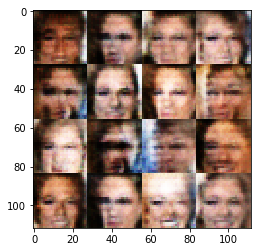

Epoch 0/1... Discriminator Loss: 1.1928... Generator Loss: 3.0658
Epoch 0/1... Discriminator Loss: 1.1238... Generator Loss: 1.1466
Epoch 0/1... Discriminator Loss: 1.0777... Generator Loss: 1.0619
Epoch 0/1... Discriminator Loss: 1.0389... Generator Loss: 1.5084
Epoch 0/1... Discriminator Loss: 0.8685... Generator Loss: 1.4568


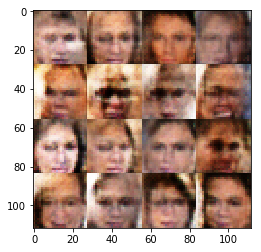

Epoch 0/1... Discriminator Loss: 1.2797... Generator Loss: 0.7932
Epoch 0/1... Discriminator Loss: 0.8600... Generator Loss: 1.4032
Epoch 0/1... Discriminator Loss: 1.0801... Generator Loss: 1.2187
Epoch 0/1... Discriminator Loss: 1.2695... Generator Loss: 2.7973
Epoch 0/1... Discriminator Loss: 0.8974... Generator Loss: 1.8114


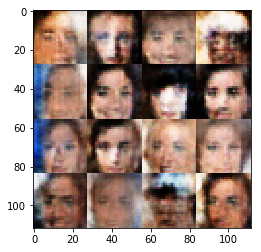

Epoch 0/1... Discriminator Loss: 0.8486... Generator Loss: 1.7993
Epoch 0/1... Discriminator Loss: 0.8521... Generator Loss: 1.7500
Epoch 0/1... Discriminator Loss: 1.0363... Generator Loss: 1.0303
Epoch 0/1... Discriminator Loss: 1.0400... Generator Loss: 1.3826
Epoch 0/1... Discriminator Loss: 2.0556... Generator Loss: 3.9850


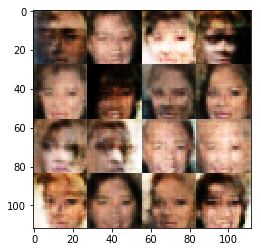

Epoch 0/1... Discriminator Loss: 0.9472... Generator Loss: 1.1648
Epoch 0/1... Discriminator Loss: 1.0446... Generator Loss: 0.9321
Epoch 0/1... Discriminator Loss: 0.8460... Generator Loss: 2.0688
Epoch 0/1... Discriminator Loss: 1.1715... Generator Loss: 2.5140
Epoch 0/1... Discriminator Loss: 0.9667... Generator Loss: 1.1491


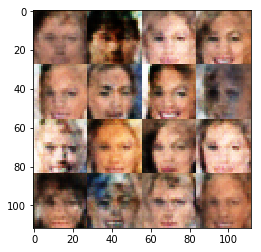

Epoch 0/1... Discriminator Loss: 0.9752... Generator Loss: 1.3054
Epoch 0/1... Discriminator Loss: 0.9030... Generator Loss: 1.3367
Epoch 0/1... Discriminator Loss: 1.0189... Generator Loss: 1.0711
Epoch 0/1... Discriminator Loss: 1.5697... Generator Loss: 0.5463
Epoch 0/1... Discriminator Loss: 1.0049... Generator Loss: 1.0182


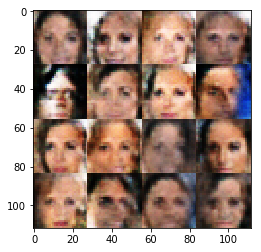

Epoch 0/1... Discriminator Loss: 1.0866... Generator Loss: 1.1242
Epoch 0/1... Discriminator Loss: 1.2358... Generator Loss: 0.9826
Epoch 0/1... Discriminator Loss: 1.1122... Generator Loss: 0.9465
Epoch 0/1... Discriminator Loss: 1.1461... Generator Loss: 2.9394
Epoch 0/1... Discriminator Loss: 0.9926... Generator Loss: 1.1064


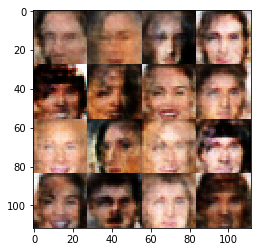

Epoch 0/1... Discriminator Loss: 1.0254... Generator Loss: 2.0688
Epoch 0/1... Discriminator Loss: 0.9415... Generator Loss: 1.1399
Epoch 0/1... Discriminator Loss: 0.8993... Generator Loss: 1.3289
Epoch 0/1... Discriminator Loss: 0.9815... Generator Loss: 1.9275


In [20]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。